In [16]:
import ast
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, hamming_loss,
                             multilabel_confusion_matrix)

In [10]:
root_dir = Path('.')  # Or specify the full path if needed

# List all directories starting with "results_MIL_with_weights_"
result_dirs = sorted(root_dir.glob('results_MIL_with_weights_*'), key=lambda x: x.name, reverse=True)

# Ensure there's at least one directory
if result_dirs:
    # Get the latest directory
    latest_dir = result_dirs[0]
    
    # Define the path to the CSV file
    csv_path = latest_dir / 'validation_predictions.csv'
    
    # Load the CSV file
    if csv_path.exists():
        predictions_df = pd.read_csv(csv_path)
        print("File retrieved:", csv_path)
        print(predictions_df.head())
    else:
        print(f"The CSV file does not exist in {latest_dir}")
else:
    print("No result directories found.")

emotion_labels = ["Anger", "Fear", "Joy", "Sadness", "Surprise"]

File retrieved: results_MIL_with_weights_2025-01-26_11-40-36\validation_predictions.csv
                                                Text      True Labels  \
0  I smoke weed alone I have a tendency to become...  [0, 0, 1, 0, 0]   
1  Nothing but fine grey and tan sand as far as m...  [0, 0, 0, 1, 0]   
2  After an evening there we were driving back be...  [0, 1, 0, 1, 0]   
3  It never freaked me out, because it happened e...  [0, 1, 0, 0, 0]   
4  Only damage done was scarring and a broken col...  [0, 1, 0, 1, 0]   

  Predicted Labels  
0  [0, 1, 0, 1, 0]  
1  [0, 0, 0, 0, 0]  
2  [1, 0, 0, 1, 0]  
3  [1, 1, 0, 1, 1]  
4  [1, 1, 0, 1, 1]  


In [6]:
# manual
# csv_path = 'results/validation_predictions.csv'

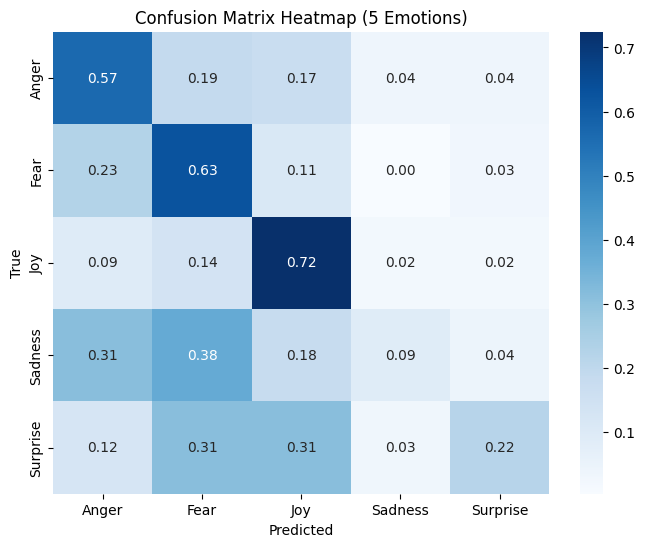

In [11]:
df = pd.read_csv(csv_path)

df["True Labels"] = df["True Labels"].apply(ast.literal_eval)
df["Predicted Labels"] = df["Predicted Labels"].apply(ast.literal_eval)

true_labels = np.array(df["True Labels"].tolist())
pred_labels = np.array(df["Predicted Labels"].tolist())

# TODO: how to calculate for multi-class?
true_classes = true_labels.argmax(axis=1)
pred_classes = pred_labels.argmax(axis=1)

cm = confusion_matrix(true_classes, pred_classes, labels=range(len(emotion_labels)))

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt=".2f", 
    cmap="Blues", 
    xticklabels=emotion_labels, 
    yticklabels=emotion_labels
)
plt.title("Confusion Matrix Heatmap (5 Emotions)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

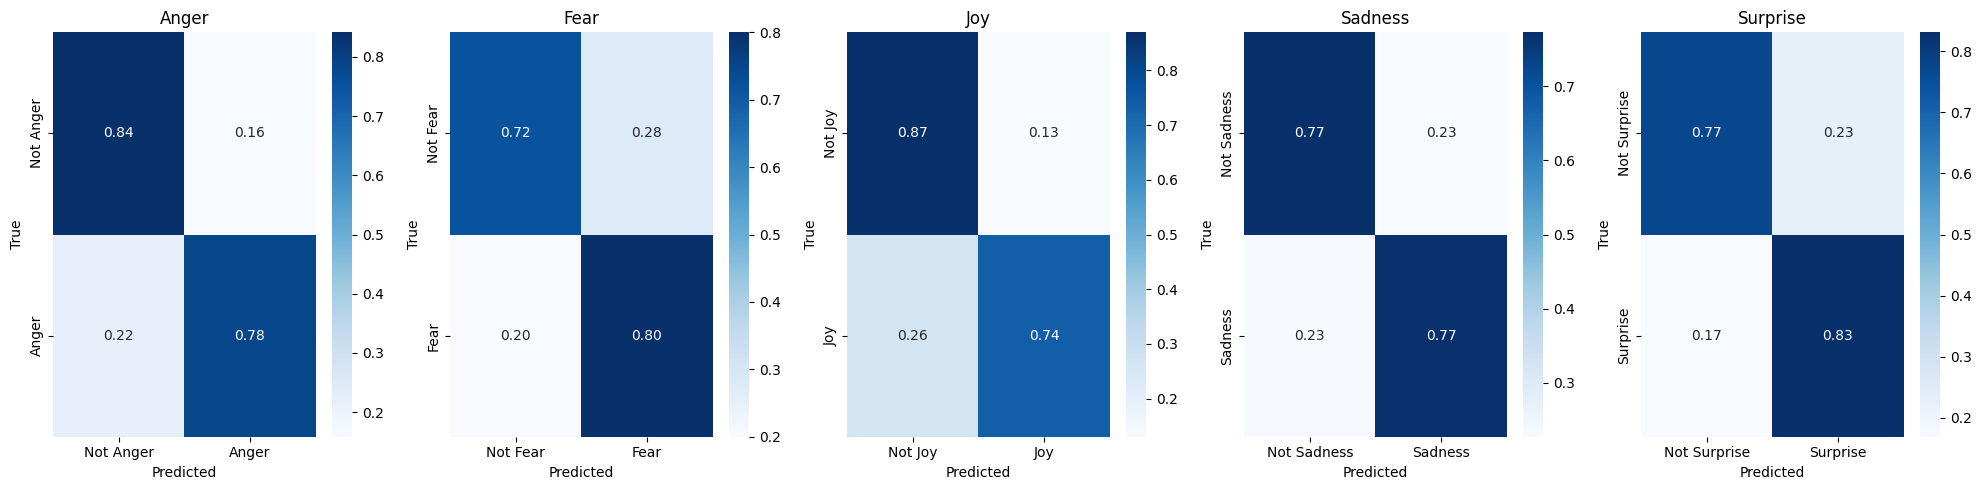

Hamming Loss: 0.19971098265895953
Subset Accuracy: 0.3569364161849711


In [17]:
df = pd.read_csv(csv_path)

df["True Labels"] = df["True Labels"].apply(ast.literal_eval)
df["Predicted Labels"] = df["Predicted Labels"].apply(ast.literal_eval)

true_labels = np.array(df["True Labels"].tolist())
pred_labels = np.array(df["Predicted Labels"].tolist())

# Multilabel confusion matrix
cm_per_class = multilabel_confusion_matrix(true_labels, pred_labels)

# Normalize confusion matrices to range 0 to 1
cm_per_class_normalized = []
for cm in cm_per_class:
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    cm_normalized[np.isnan(cm_normalized)] = 0  # Handle division by zero
    cm_per_class_normalized.append(cm_normalized)

# Plot heatmaps for each class
fig, axes = plt.subplots(1, len(emotion_labels), figsize=(20, 5))
for i, label in enumerate(emotion_labels):
    sns.heatmap(
        cm_per_class_normalized[i],
        annot=True,
        fmt=".2f",  # Display normalized values with 2 decimal places
        cmap="Blues",
        xticklabels=["Not " + label, label],
        yticklabels=["Not " + label, label],
        ax=axes[i],
    )
    axes[i].set_title(label)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("True")
plt.tight_layout()
plt.show()

# Calculate and display additional metrics
hamming = hamming_loss(true_labels, pred_labels)
subset_acc = accuracy_score(true_labels, pred_labels)

print("Hamming Loss:", hamming)
print("Subset Accuracy:", subset_acc)


In [12]:
# Classification Report
print("\nMultilabel Classification Report:")
for i, label in enumerate(emotion_labels):
    print(f"Label: {label}")
    print(classification_report(true_labels[:, i], pred_labels[:, i], zero_division=0))


Multilabel Classification Report:
Label: Anger
              precision    recall  f1-score   support

           0       0.97      0.84      0.90       618
           1       0.37      0.78      0.50        74

    accuracy                           0.84       692
   macro avg       0.67      0.81      0.70       692
weighted avg       0.91      0.84      0.86       692

Label: Fear
              precision    recall  f1-score   support

           0       0.73      0.72      0.73       297
           1       0.79      0.80      0.80       395

    accuracy                           0.77       692
   macro avg       0.76      0.76      0.76       692
weighted avg       0.77      0.77      0.77       692

Label: Joy
              precision    recall  f1-score   support

           0       0.91      0.87      0.89       529
           1       0.63      0.74      0.68       163

    accuracy                           0.84       692
   macro avg       0.77      0.80      0.79       692
wei